# Timeseries analysis: domain trajectories of expert-annotated and synthetically-annotated patients

This notebook analyses the ICF levels in each domain over time for each patient for both the human-annotated and the synthetically-labelled (using the NLP team's model) patients. This analysis revealed a number of issues and areas for improvement in both the framing of the timeseries learning task and the annotation pipeline.


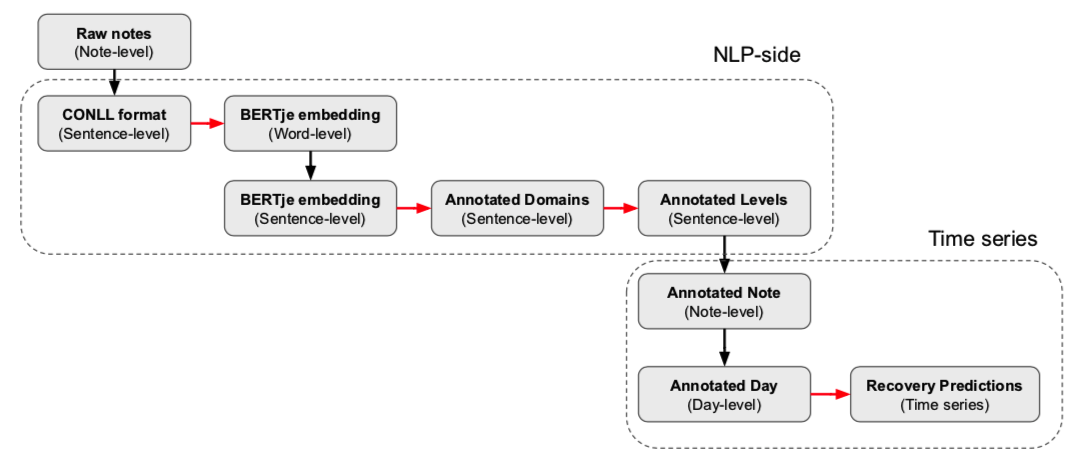

In [1]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import statsmodels
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

# Make graphics nice
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set sensible defaults
sns.set()
sns.set_style("ticks")
sns.set_context('paper')

# Timeseries modelling with human-annotated test annotations

In [2]:
dfs = []
for path in Path('../testing/completed').glob('*.xlsx'):
    dfs.append(pd.read_excel(path))

df_test = pd.concat(dfs)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1181 entries, 0 to 56
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   centre      1181 non-null   object 
 1   patient_id  1181 non-null   int64  
 2   note_id     1181 non-null   int64  
 3   note_csn    1181 non-null   int64  
 4   date        1181 non-null   object 
 5   type        1103 non-null   object 
 6   discard     3 non-null      float64
 7   STM_level   91 non-null     float64
 8   INS_level   111 non-null    object 
 9   BER_level   13 non-null     float64
 10  FAC_level   186 non-null    float64
 11  note        1181 non-null   object 
dtypes: float64(4), int64(3), object(5)
memory usage: 119.9+ KB


In [3]:
df_test.patient_id.unique()

array([1848618, 2977287, 7052538,  772676, 6403079, 8555667, 3174190,
       1825193, 1516667, 1827868, 8012257, 1826470, 1701305, 1733802,
       1830568, 1828353, 6779382, 1829083, 1833136])

In [5]:
df_test[~df_test.INS_level.isna()].INS_level.values

array([3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0,
       2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0,
       2.0, 1.0, 1.0, 2.0, 3.0, 3.0, 0, 'd', 1, 1, 1, 2, 2, 2, 4, 3, 0.0,
       2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 1.0, 2.0,
       0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 3.0, 4.0,
       4.0, 3.0, 2.0, 2.0, 2.0, 4.0, 3.0, 4.0, 4.0, 4.0, 0.0, 1.0, 0.0,
       0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0,
       4.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0,
       3.0, 3.0, 3.0], dtype=object)

In [6]:
# Fill dodgy INS values and convert to numeric column
df_test.loc[df_test.INS_level == 'd', 'INS_level'] = np.nan
df_test['INS_level'] = pd.to_numeric(df_test['INS_level'])

In [7]:
DOMAINS = ['STM_level', 'FAC_level', 'INS_level', 'BER_level']
df_test[DOMAINS].describe()

,STM_level,FAC_level,INS_level,BER_level
count,91.000000,186.000000,110.000000,13.000000
mean,1.593407,2.553763,1.945455,2.769231
std,1.010808,1.856999,1.021210,1.235168
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,2.000000
50%,1.000000,4.000000,2.000000,3.000000
75%,3.000000,4.000000,3.000000,4.000000
max,3.000000,5.000000,4.000000,4.000000


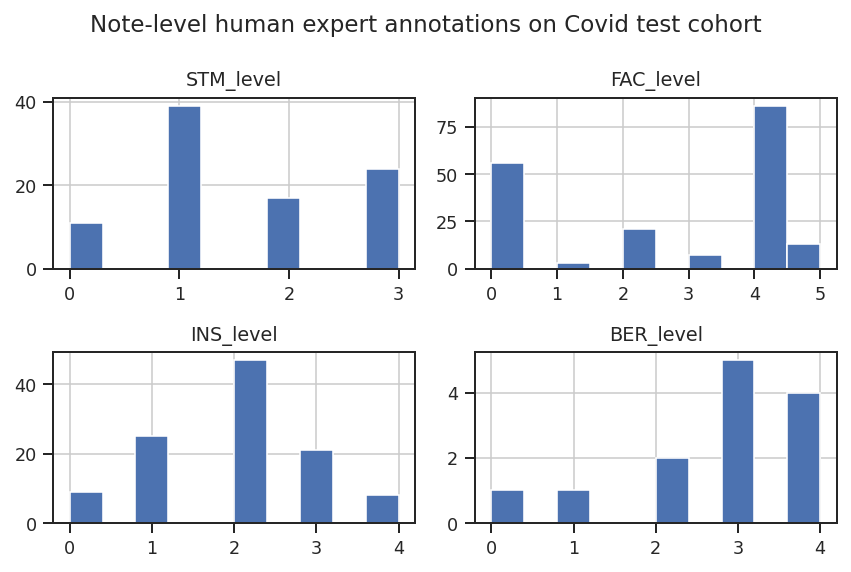

In [8]:
df_test[DOMAINS].hist()
plt.suptitle('Note-level human expert annotations on Covid test cohort')
plt.tight_layout()

In [9]:
_df_test = df_test.groupby(['patient_id', 'date']).mean()[DOMAINS].reset_index()
_df_test

,patient_id,date,STM_level,FAC_level,INS_level,BER_level
0,772676,2020-03-30,NaN,NaN,NaN,NaN
1,772676,2020-04-06,NaN,NaN,NaN,NaN
2,772676,2020-04-21,NaN,NaN,NaN,NaN
3,772676,2020-04-29,NaN,NaN,NaN,NaN
4,772676,2020-06-16,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
306,8555667,2020-09-02,NaN,NaN,NaN,NaN
307,8555667,2020-09-03,NaN,NaN,NaN,NaN
308,8555667,2020-09-21,NaN,NaN,NaN,NaN
309,8555667,2020-09-22,NaN,NaN,NaN,NaN


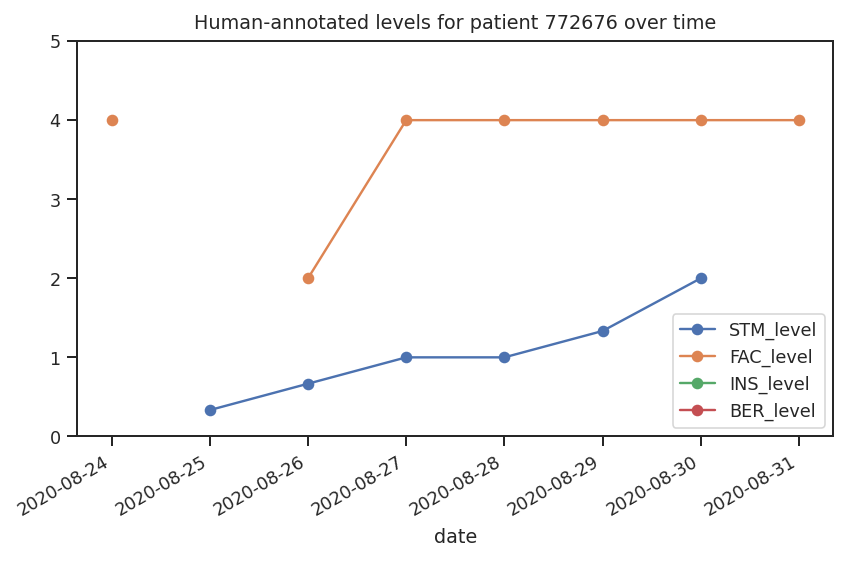

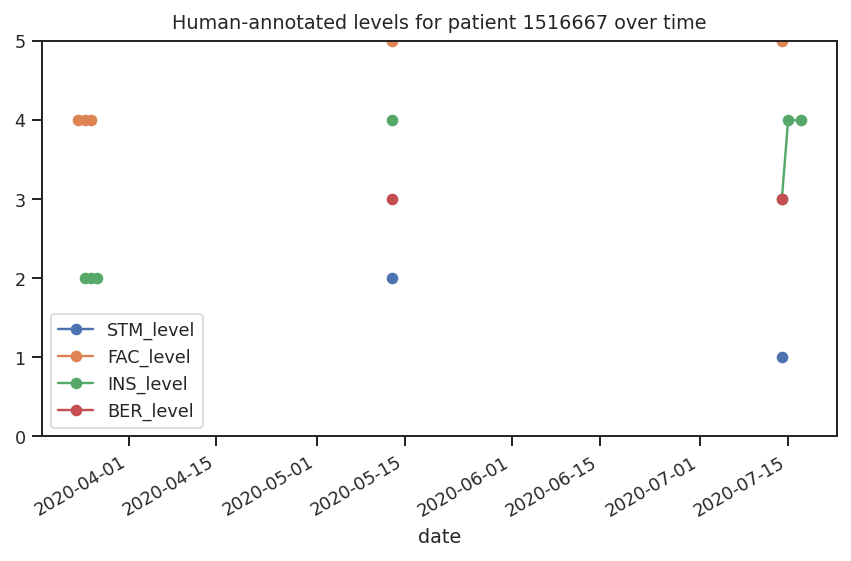

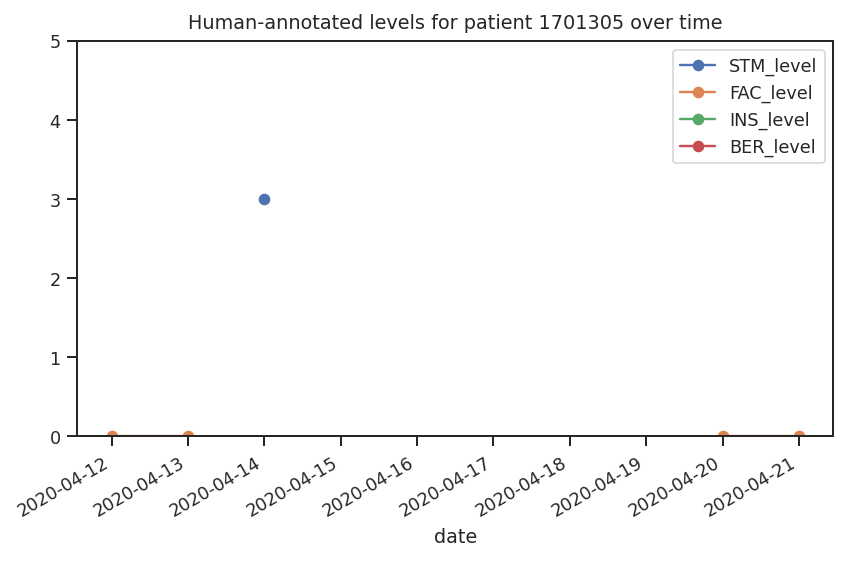

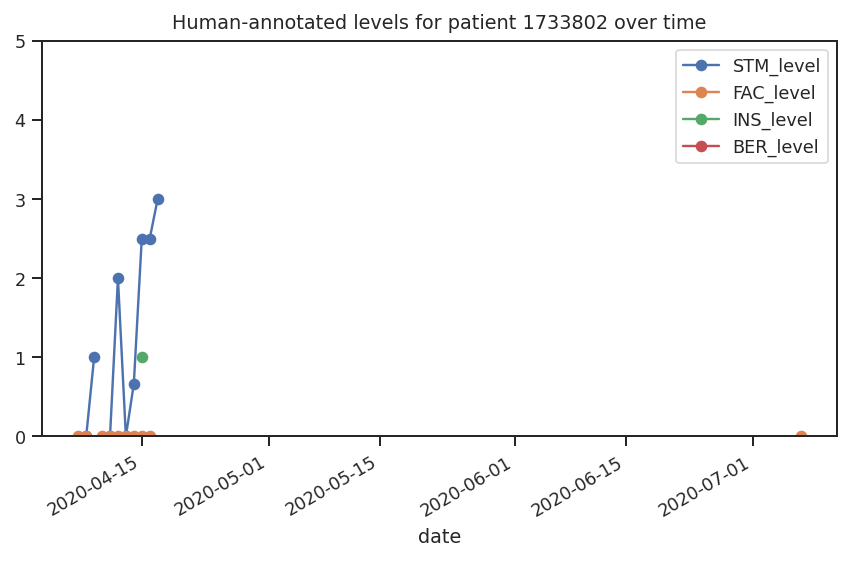

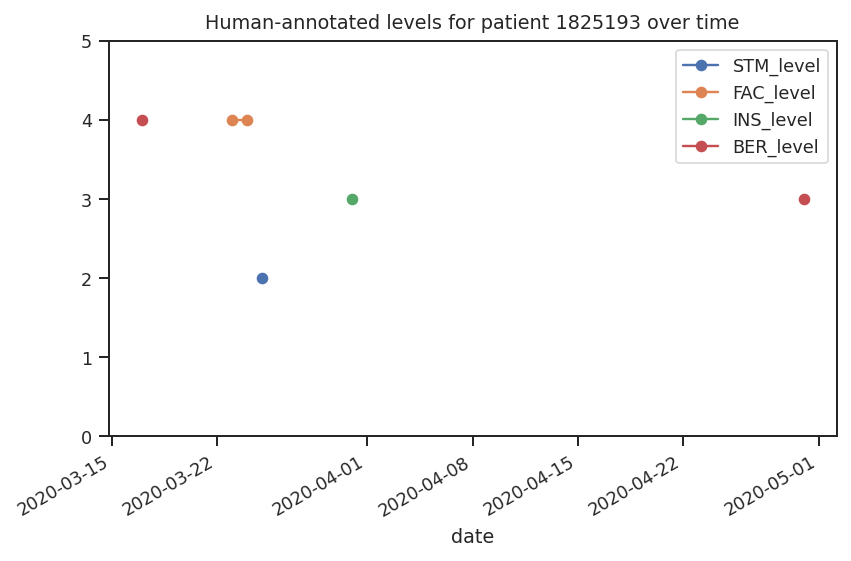

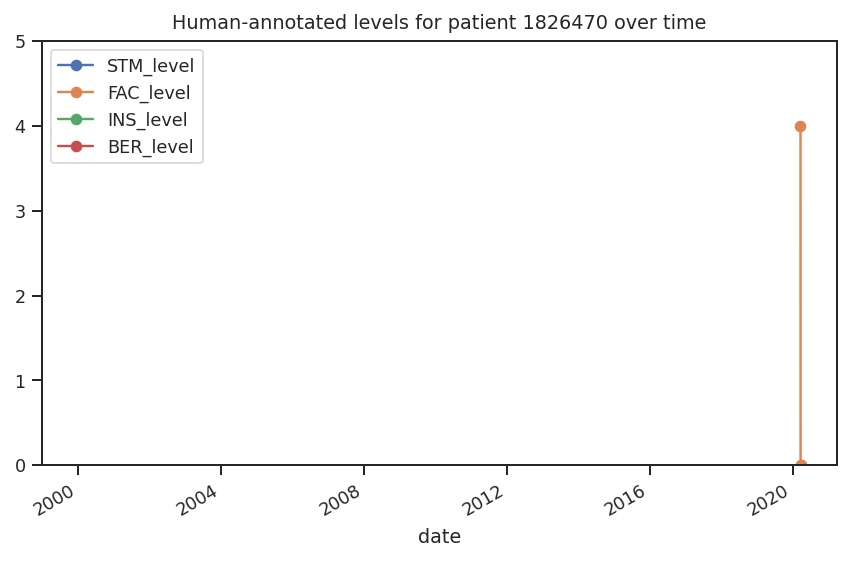

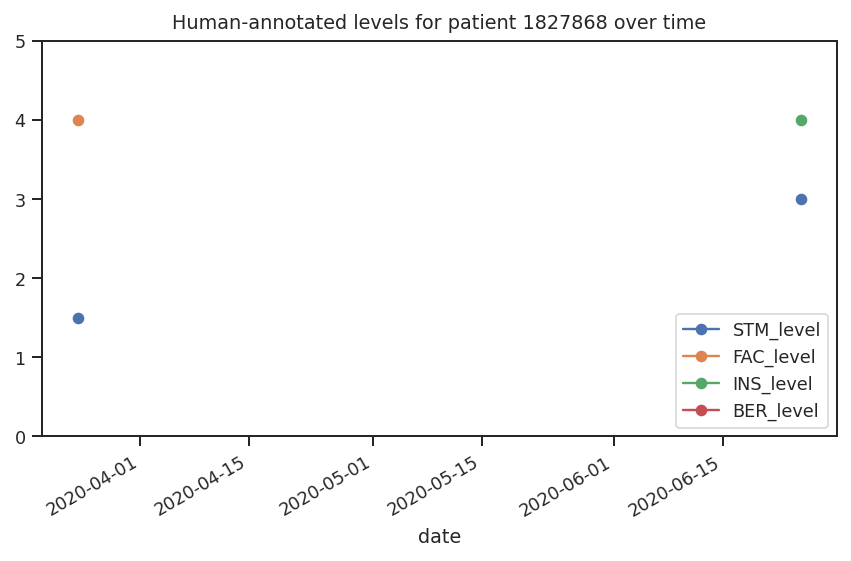

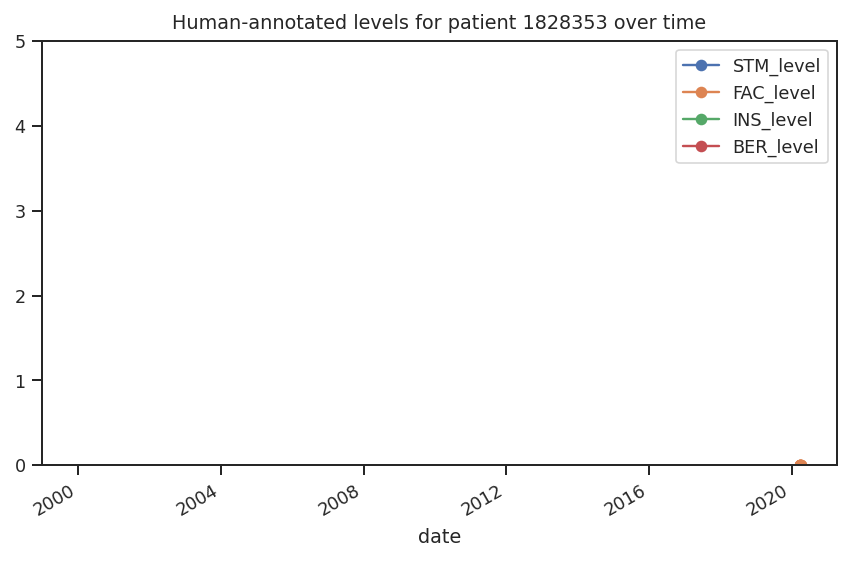

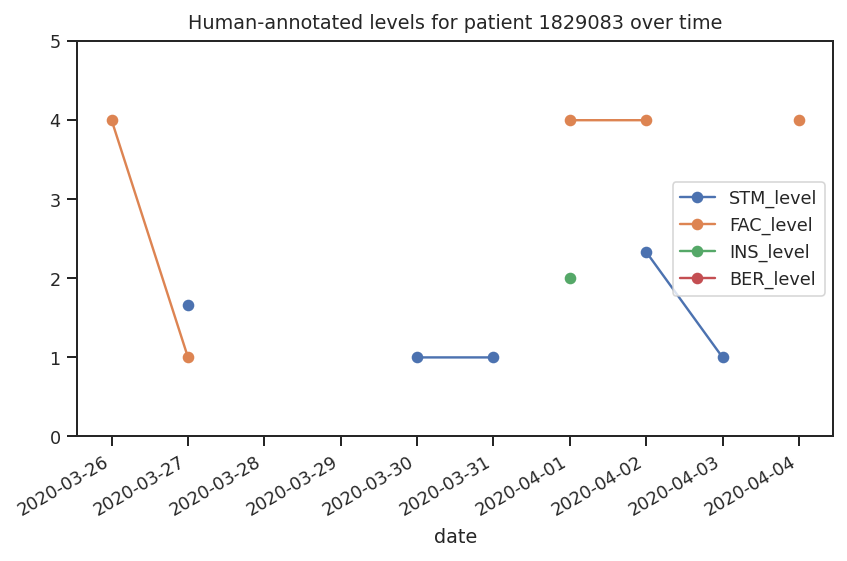

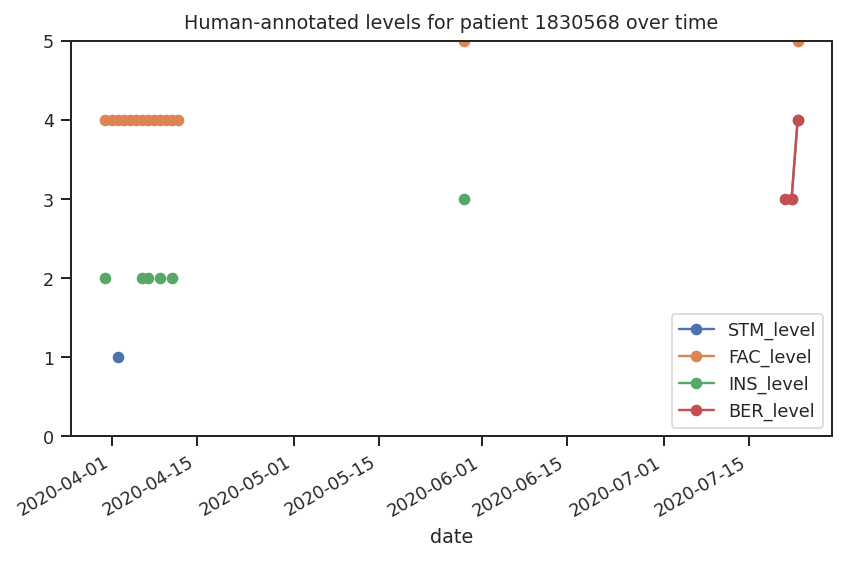

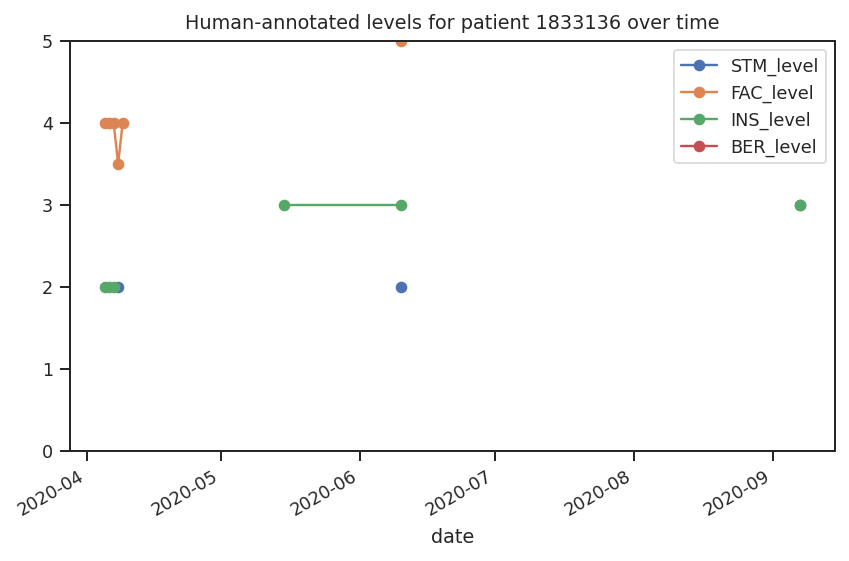

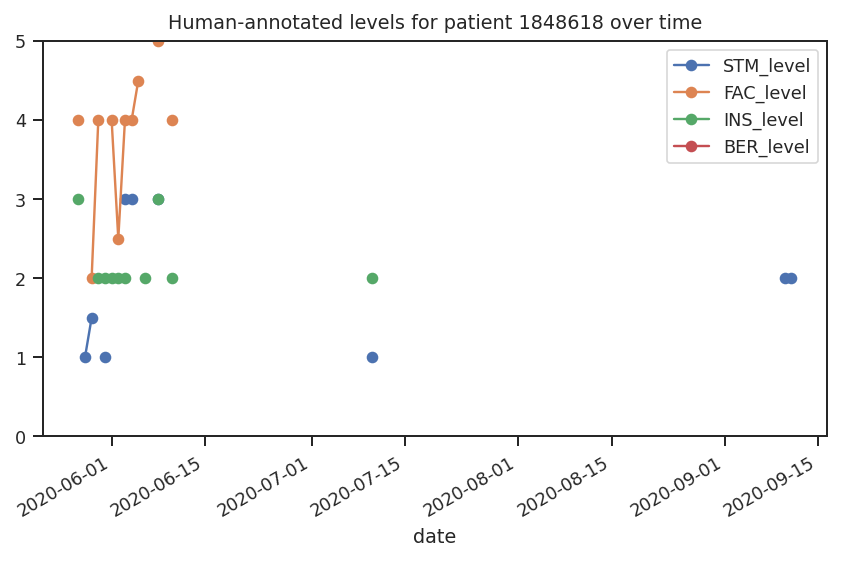

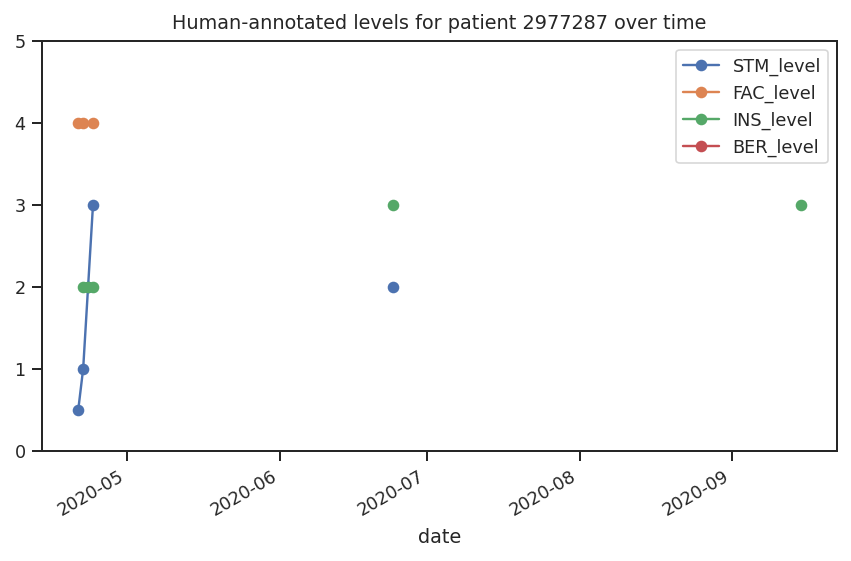

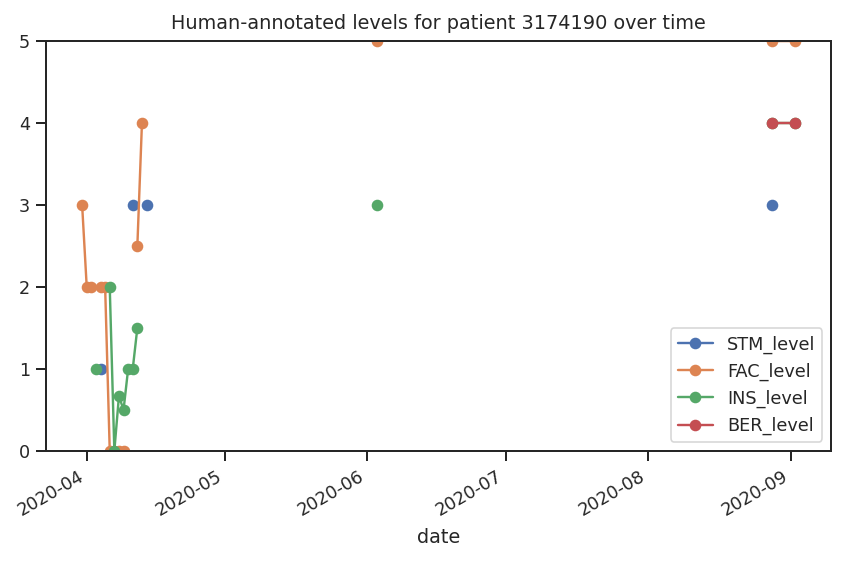

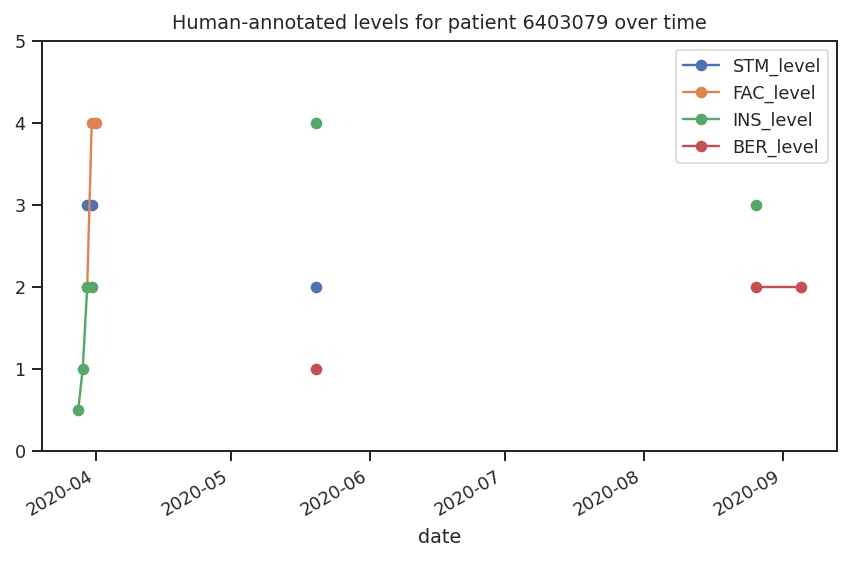

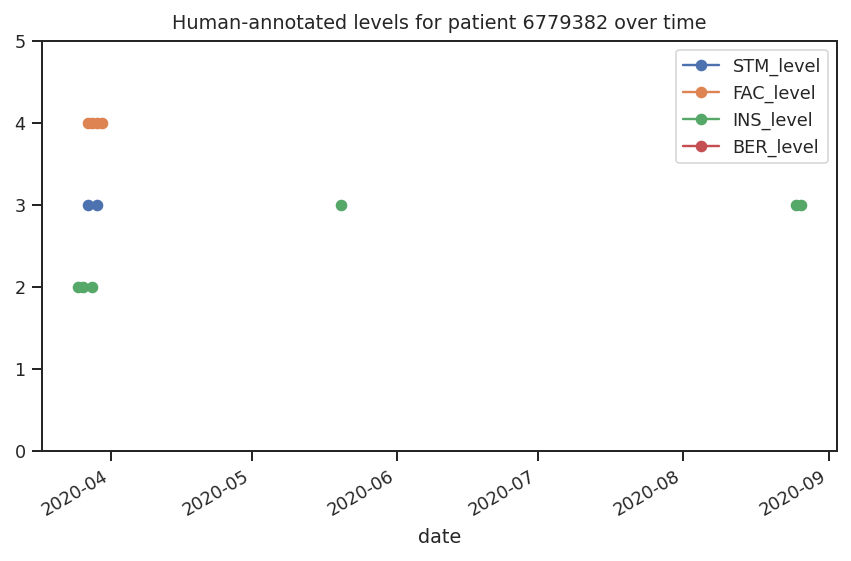

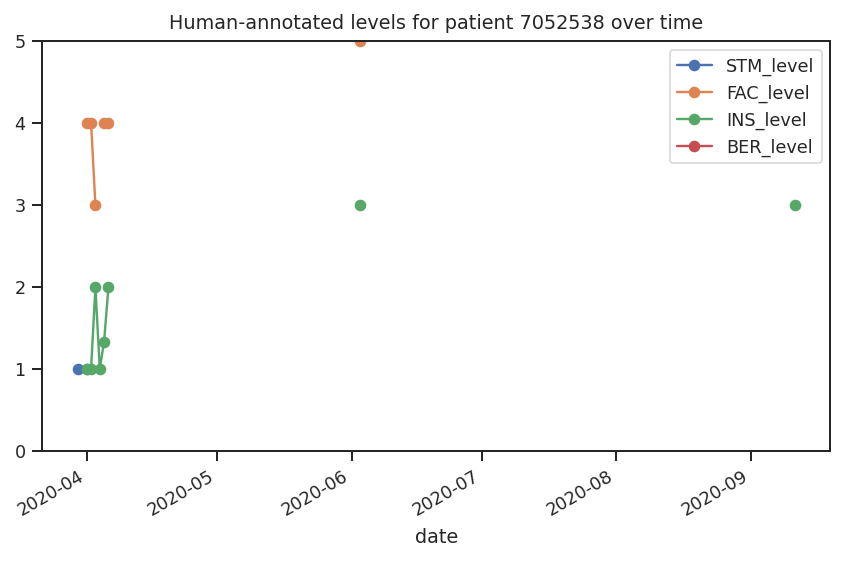

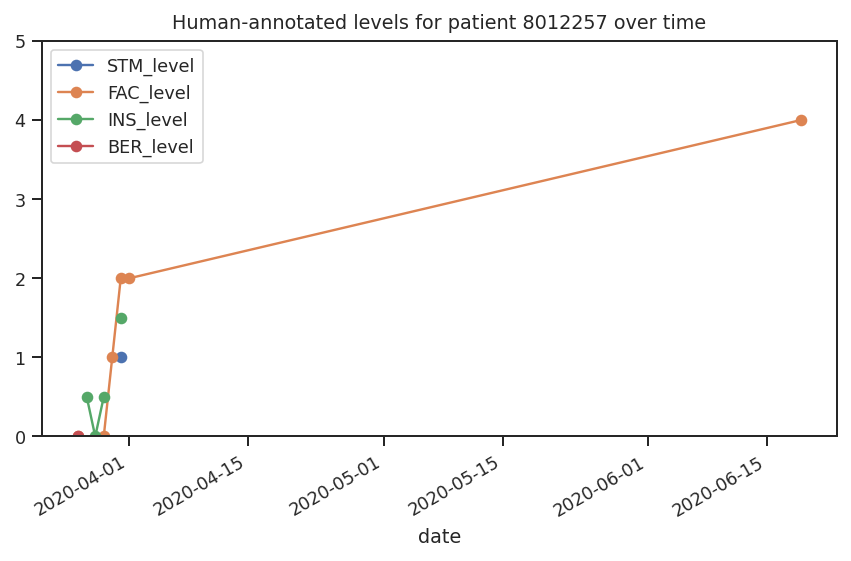

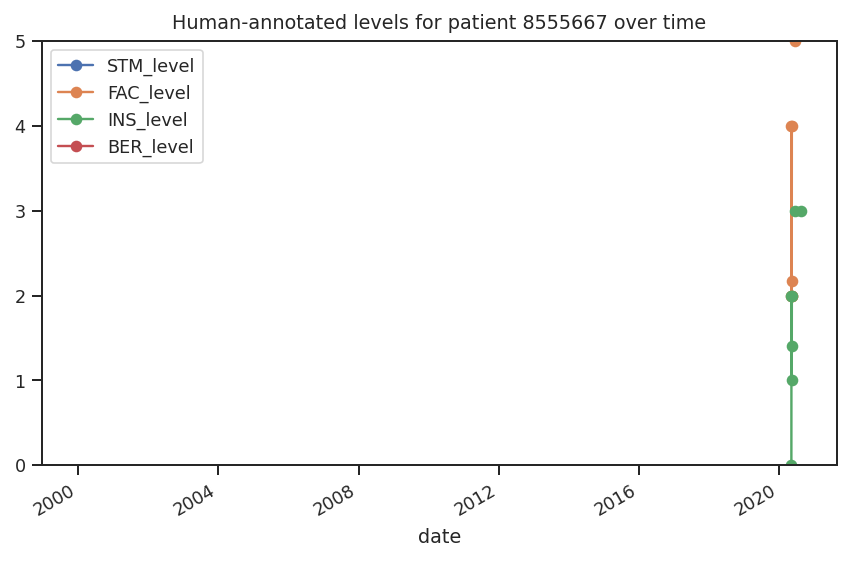

In [10]:
for pid in _df_test.patient_id.unique():
    data = _df_test[_df_test.patient_id == pid].sort_values(by='date', ascending=True)
    data['date'] = pd.to_datetime(data['date'])
    data.plot(kind='line', x='date', y=DOMAINS, marker='o')
#     plt.xlim('2020-3-15', '2020-09-01')
    plt.ylim(0, 5)
    plt.title(f"Human-annotated levels for patient {pid} over time")
    plt.tight_layout()
    plt.show()

# Timeseries modelling with synthetic BERTje-based annotations

In [11]:
# Load in the training data
df = pd.read_csv('../data/timeseries_covid_train_synth.tsv', sep='\t')
df.shape

(2485, 15)

In [12]:
df.patient_id.unique()

array([1824900, 4883738, 1825349, 1826096, 1826295, 3286406, 4099178,
       4174967, 1827925, 1828106, 1827855, 1828039, 7474489, 7391983,
       8227934, 1828811, 1829326, 1829557, 7704030, 1830607, 2974474,
       8293683, 1830514, 9426094, 1628243, 1831152, 4715790, 7594581,
       1834688, 1834711, 1834253,  957223, 4190540, 7651109, 4667364,
       6260057, 7843710, 8920715, 3850656, 8776560, 1845127, 1847708])

In [13]:
DOMAINS = ['stm_lev', 'fac_lev']

In [14]:
df[DOMAINS].describe()

,stm_lev,fac_lev
count,298.000000,22.000000
mean,1.590167,2.714837
std,0.667532,0.865150
min,0.401401,0.108253
25%,1.043697,2.300286
50%,1.518394,2.750582
75%,2.138082,3.391070
max,3.370623,3.814284


In [15]:
df.shape

(2485, 15)

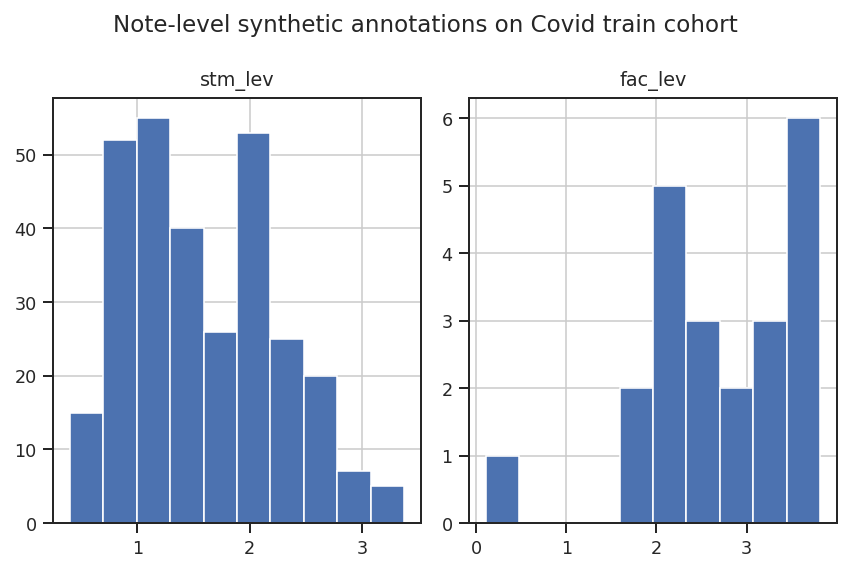

In [16]:
df[DOMAINS].hist()
plt.suptitle('Note-level synthetic annotations on Covid train cohort')
plt.tight_layout()

In [17]:
_df = df.groupby(['patient_id', 'date']).mean()[DOMAINS].reset_index()
_df

,patient_id,date,stm_lev,fac_lev
0,957223,2020-04-11,1.373805,NaN
1,957223,2020-04-12,1.168672,NaN
2,957223,2020-04-13,1.042510,NaN
3,957223,2020-04-14,NaN,3.121183
4,957223,2020-04-15,1.497492,NaN
...,...,...,...,...
666,9426094,2020-06-03,NaN,NaN
667,9426094,2020-07-03,NaN,NaN
668,9426094,2020-07-09,NaN,NaN
669,9426094,2020-09-07,NaN,NaN


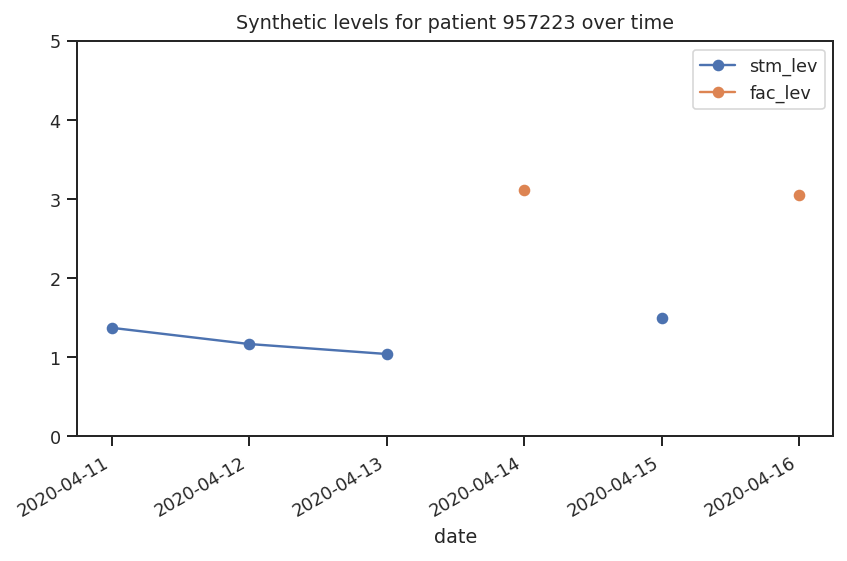

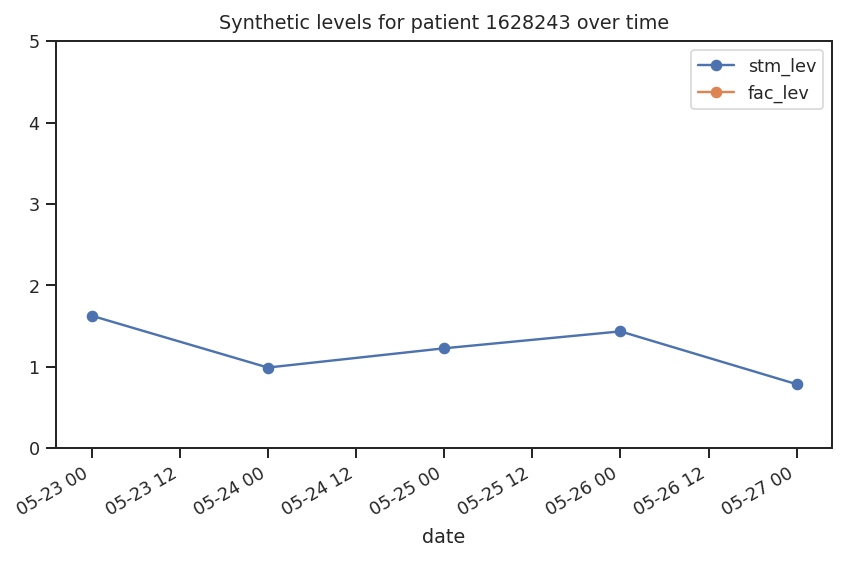

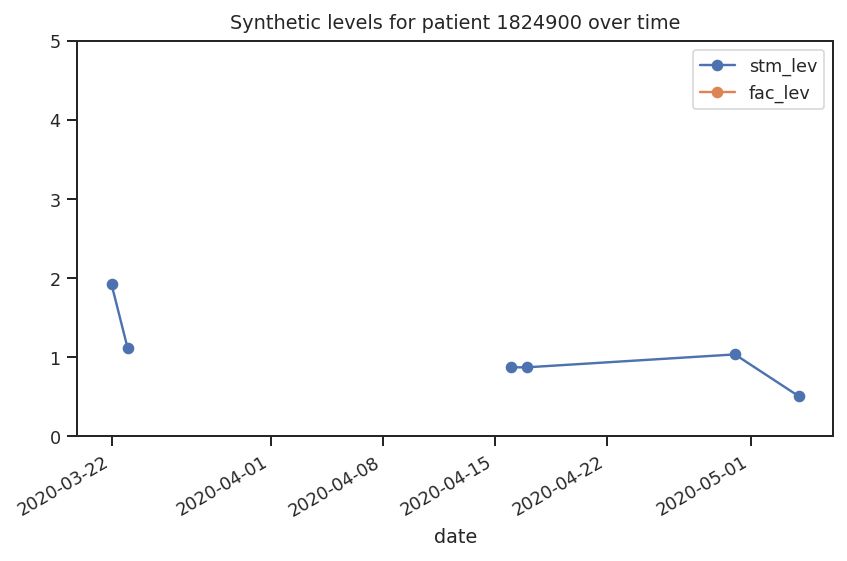

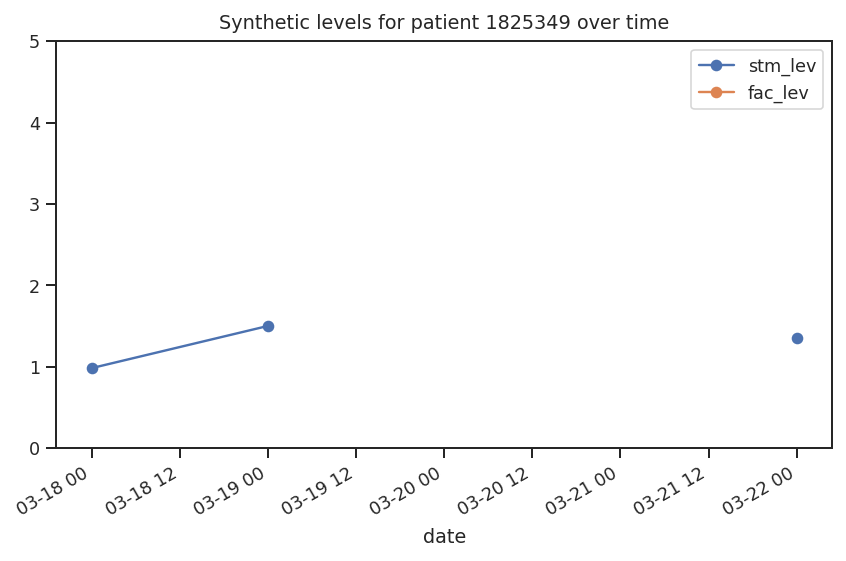

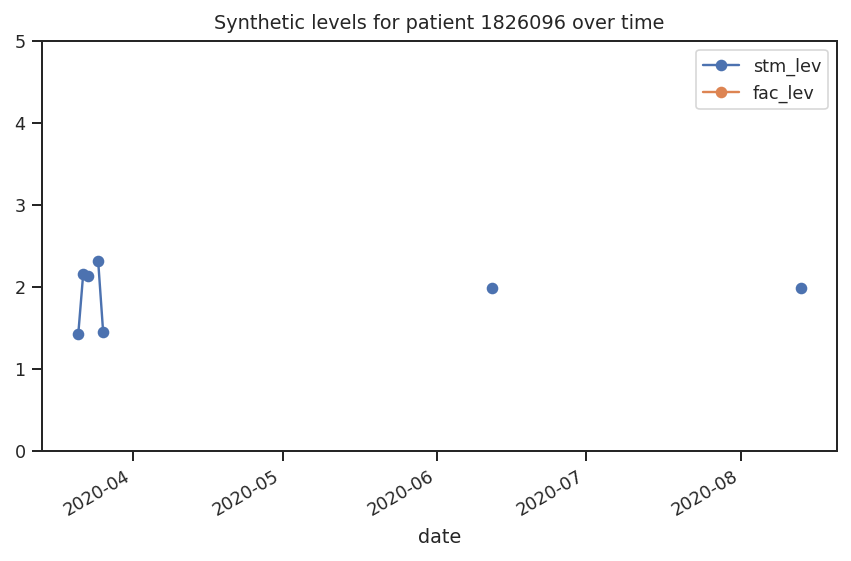

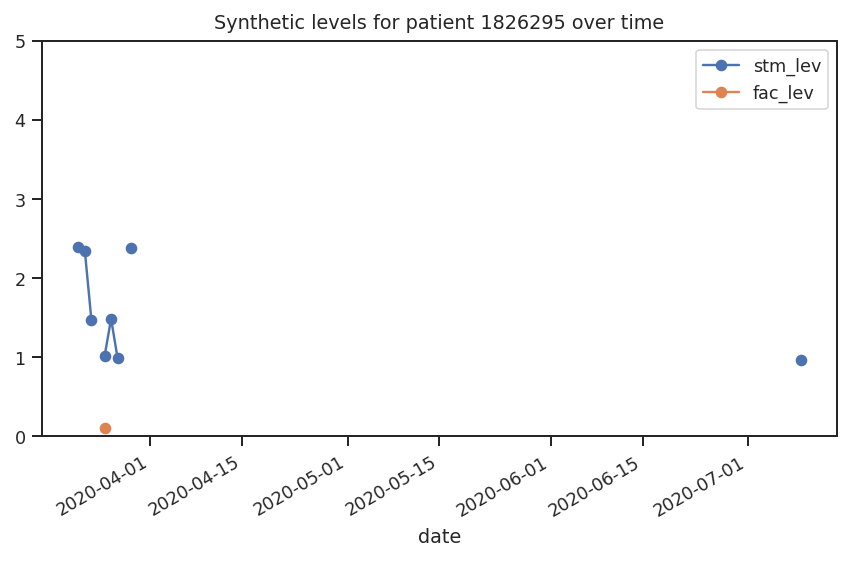

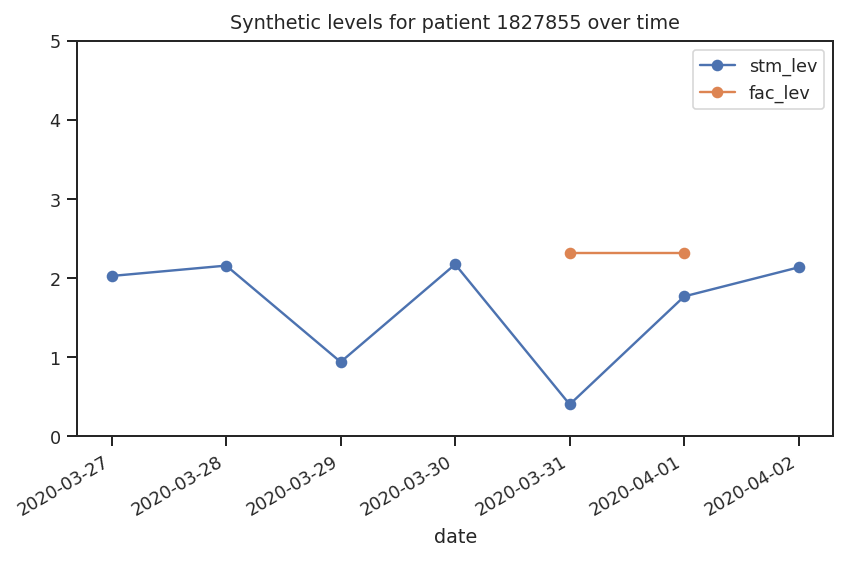

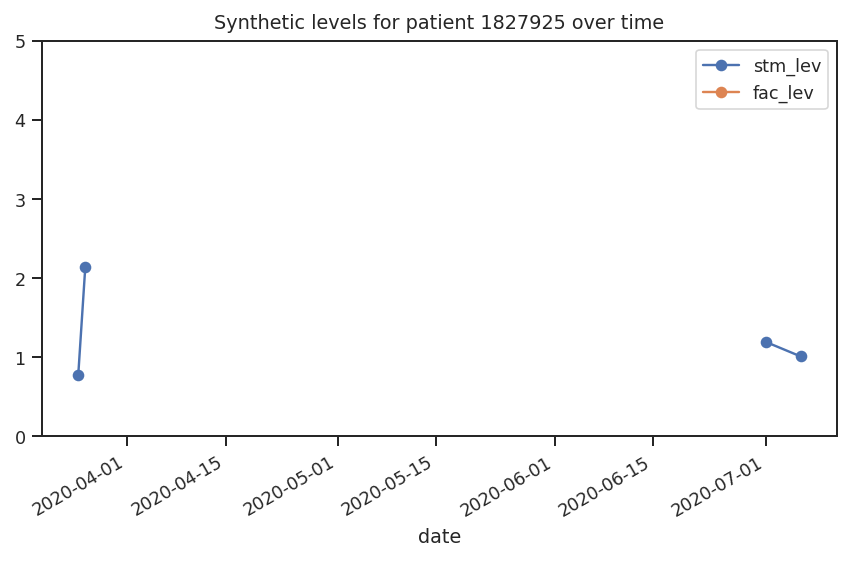

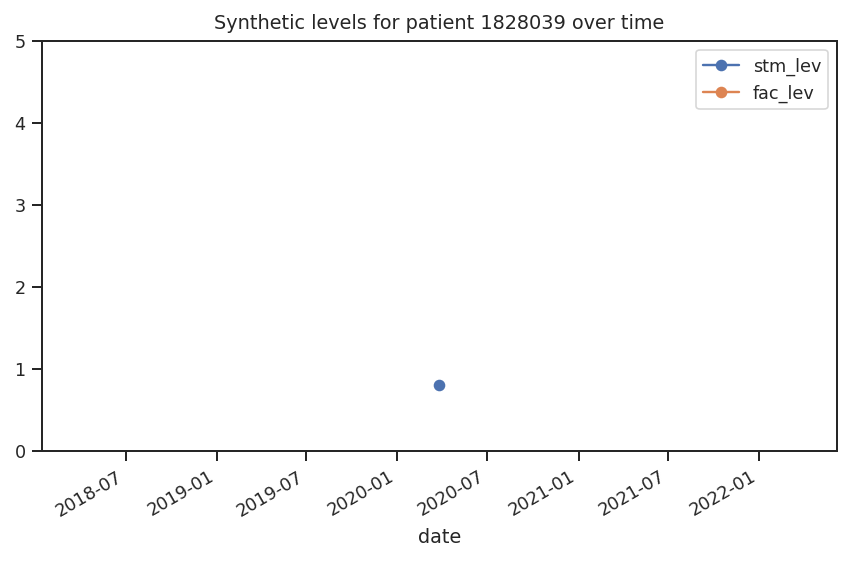

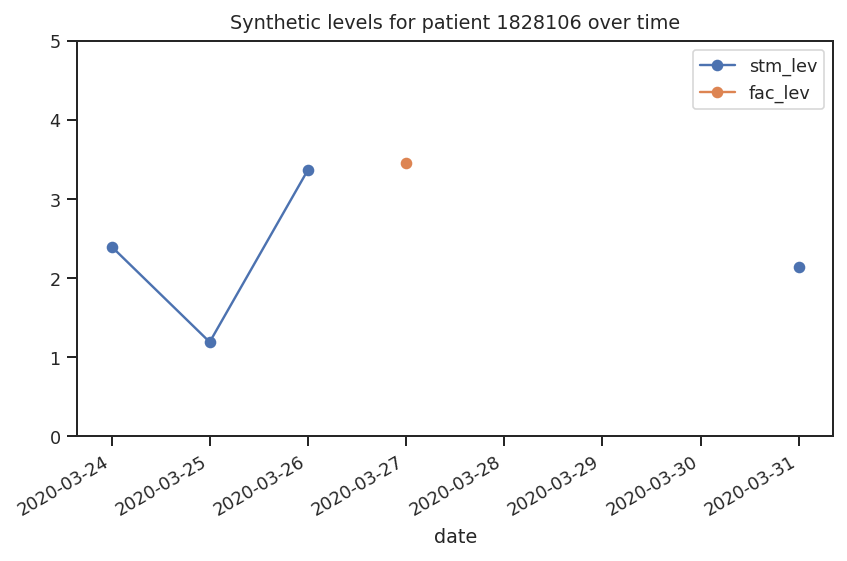

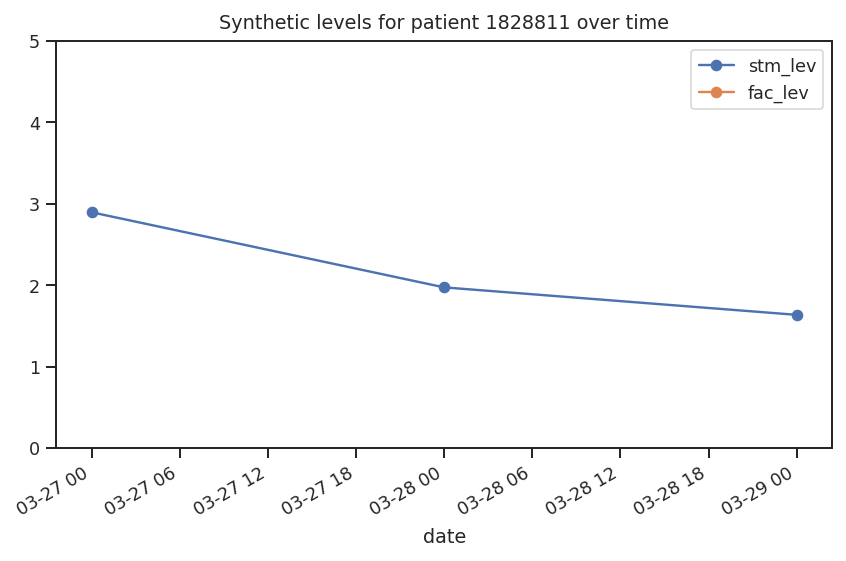

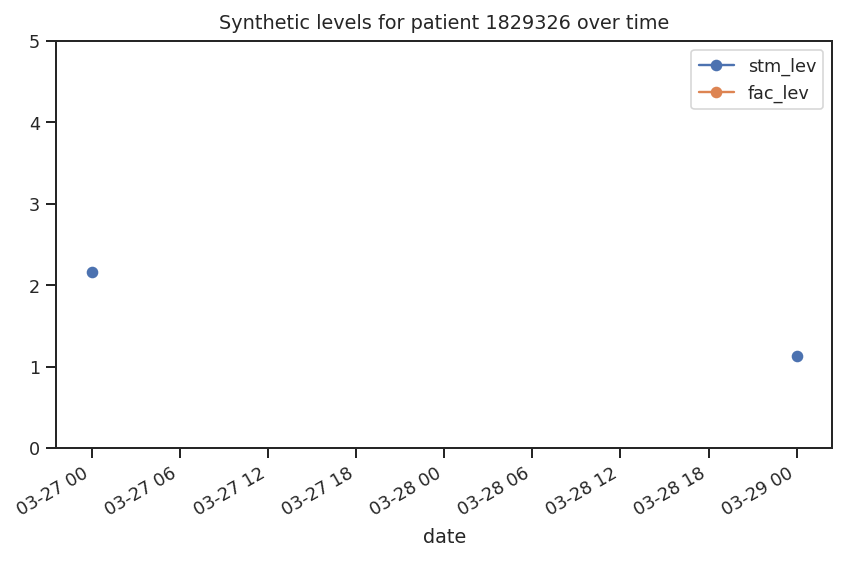

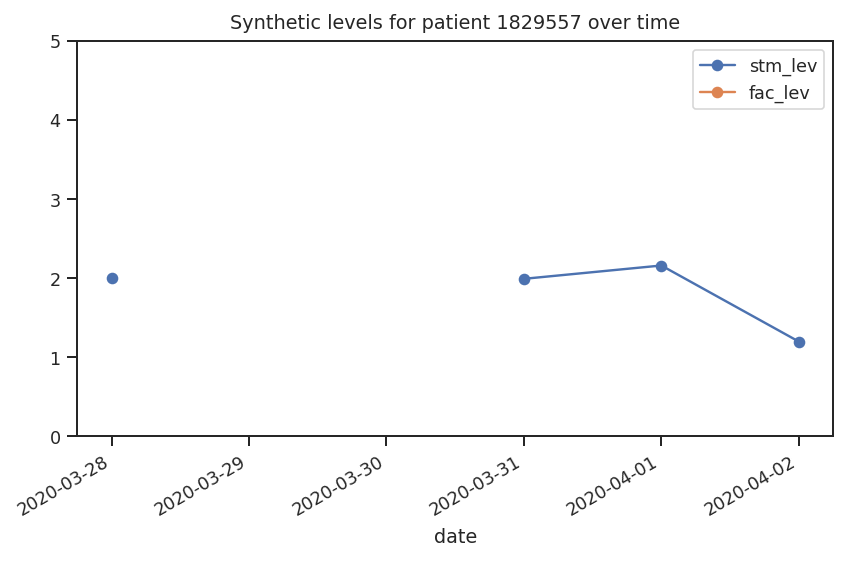

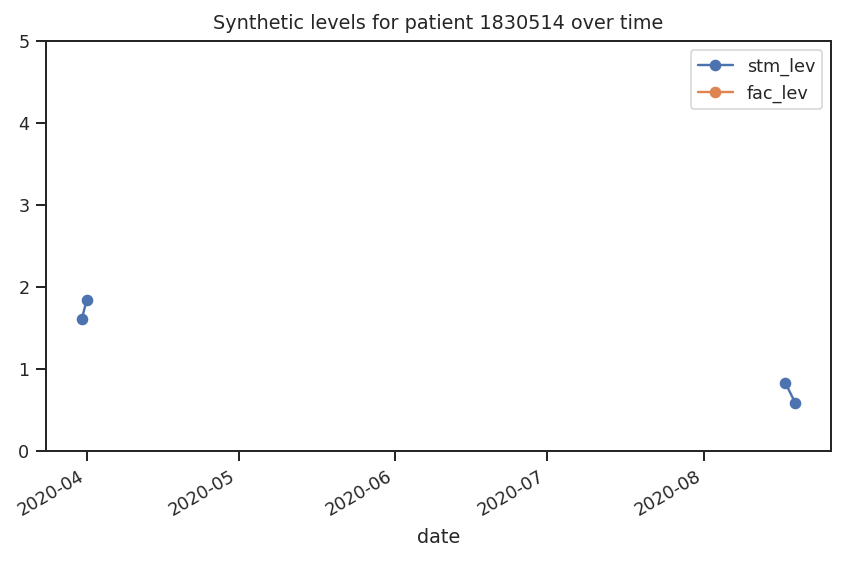

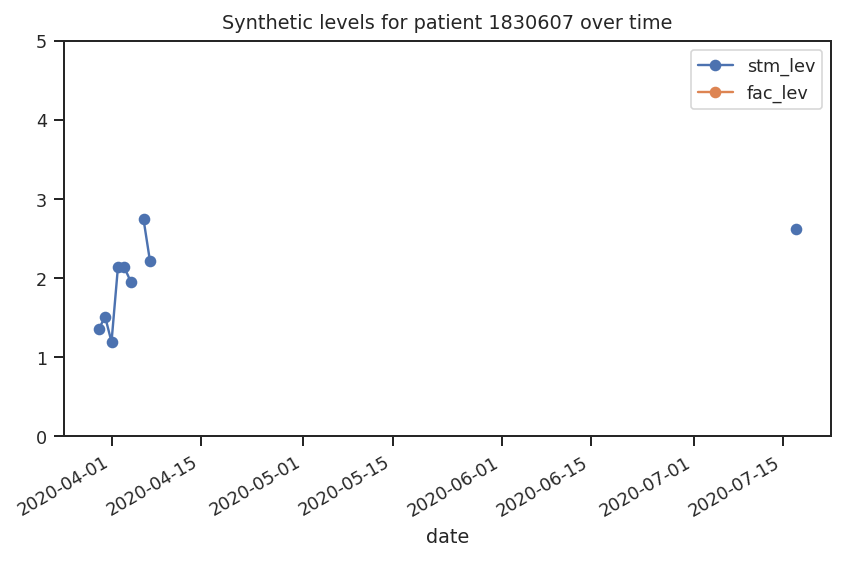

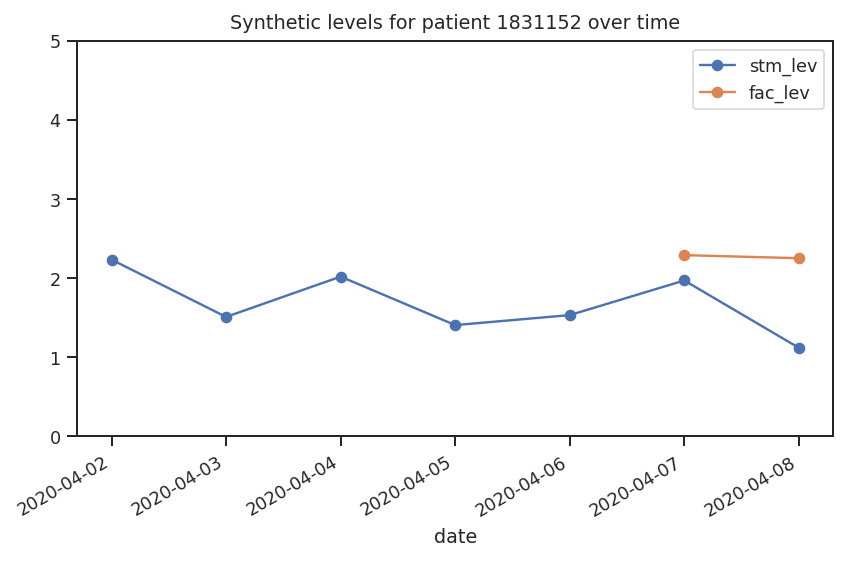

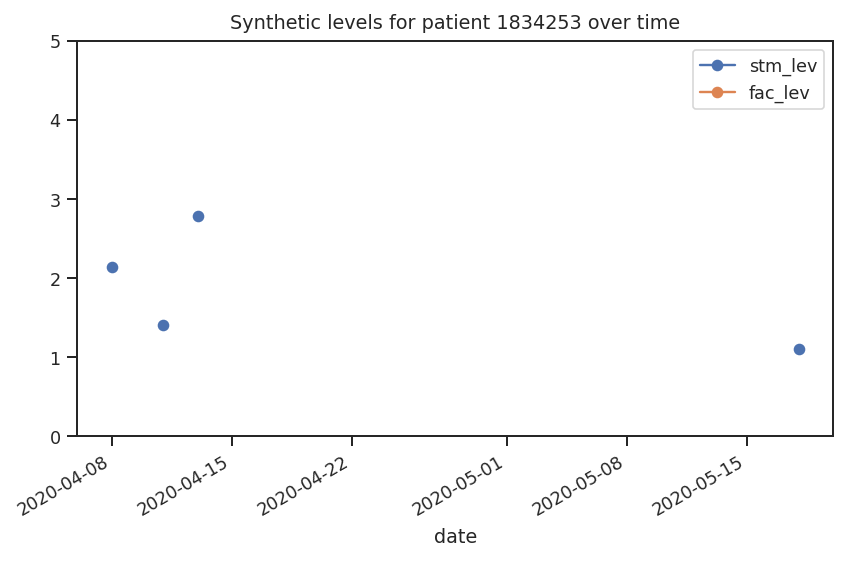

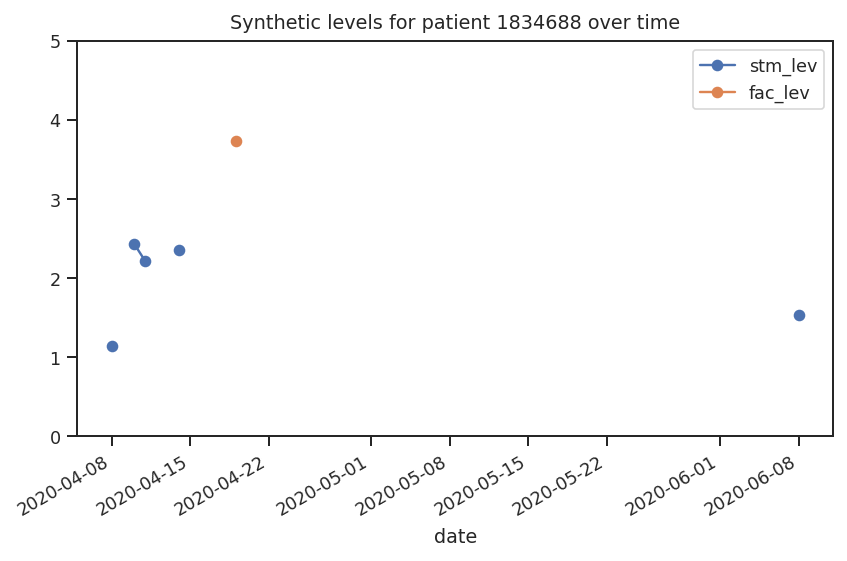

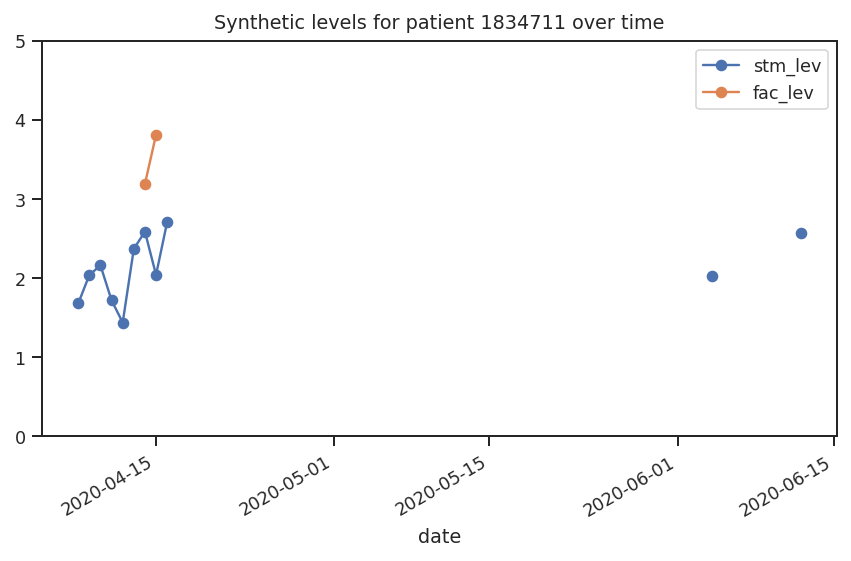

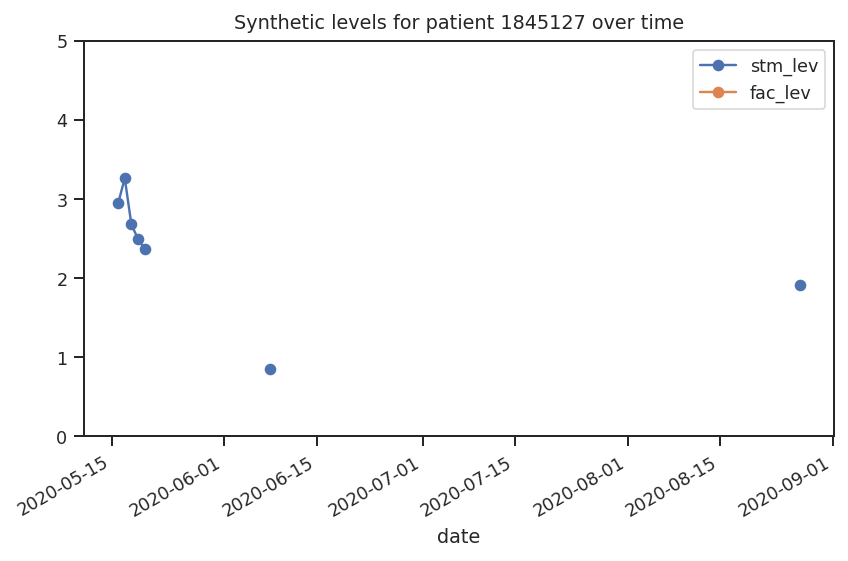

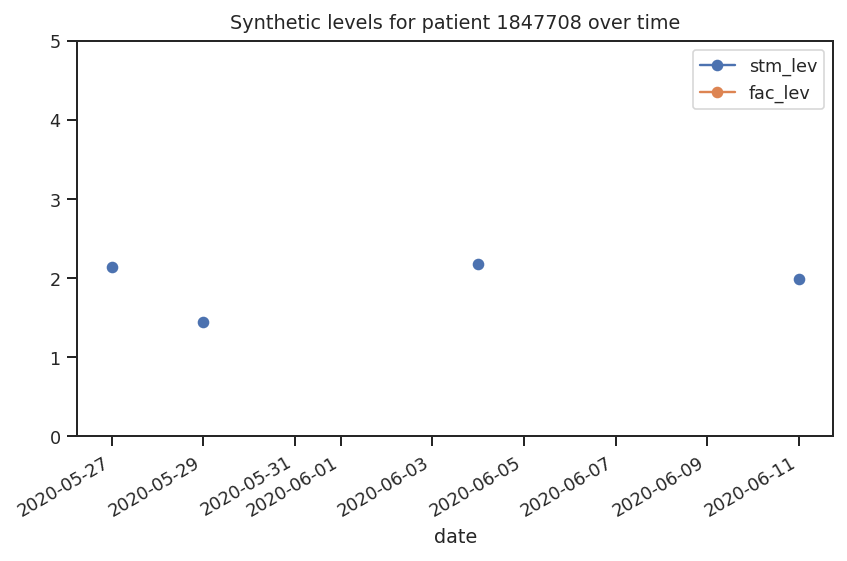

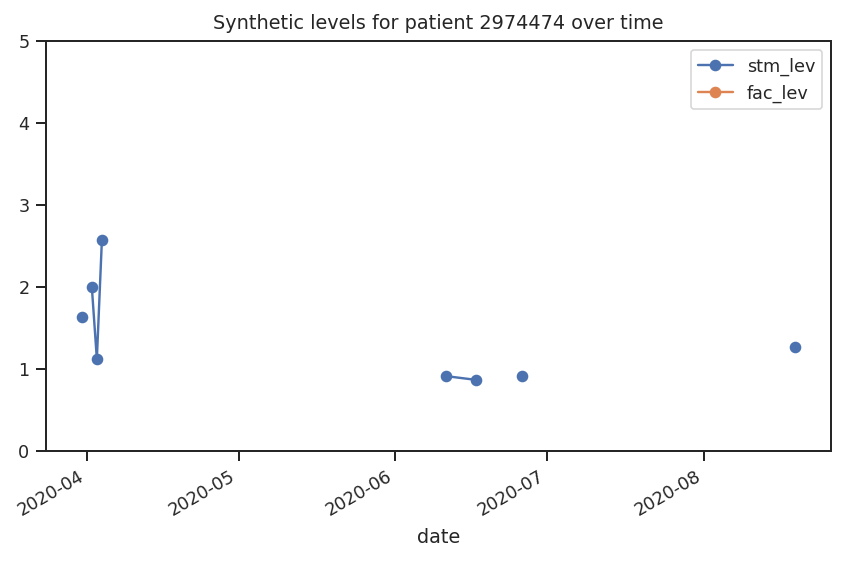

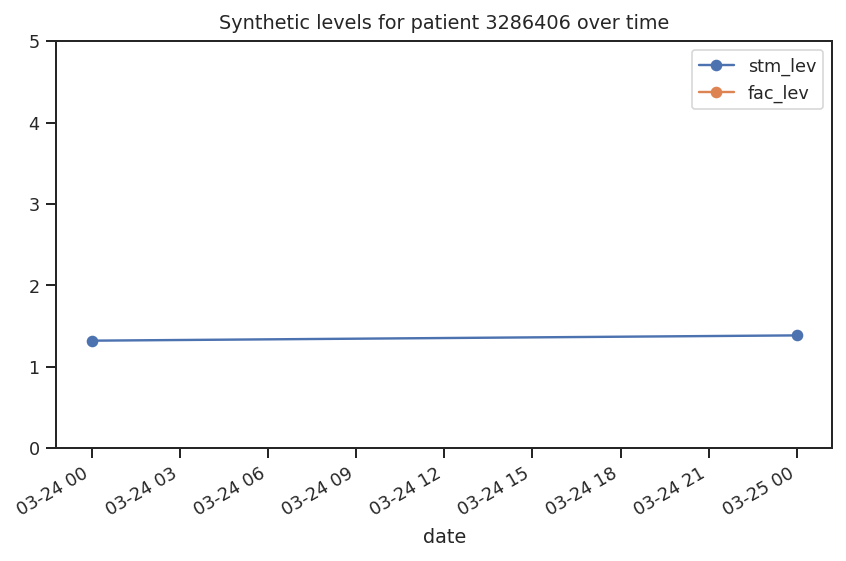

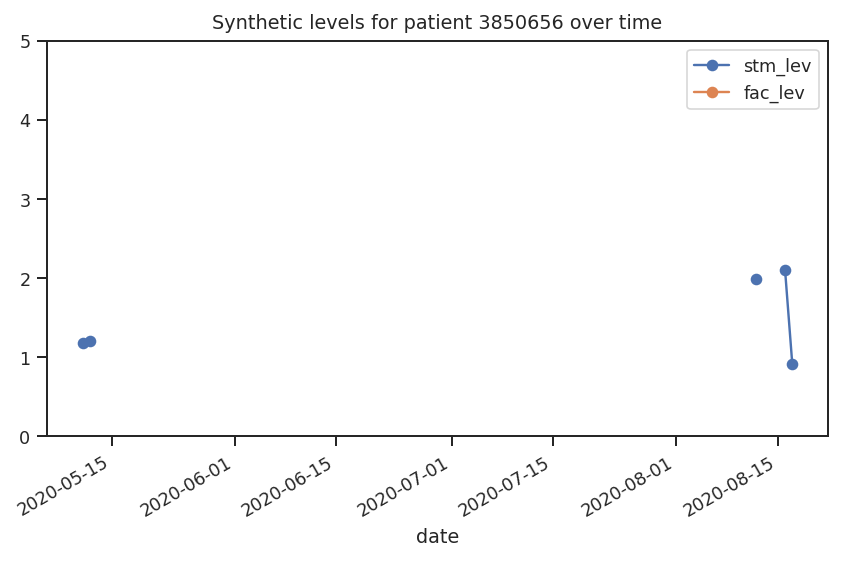

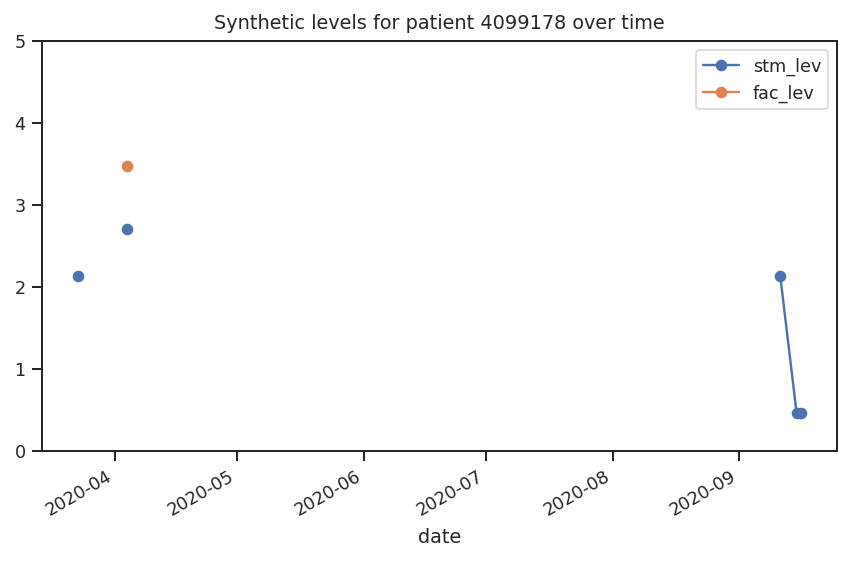

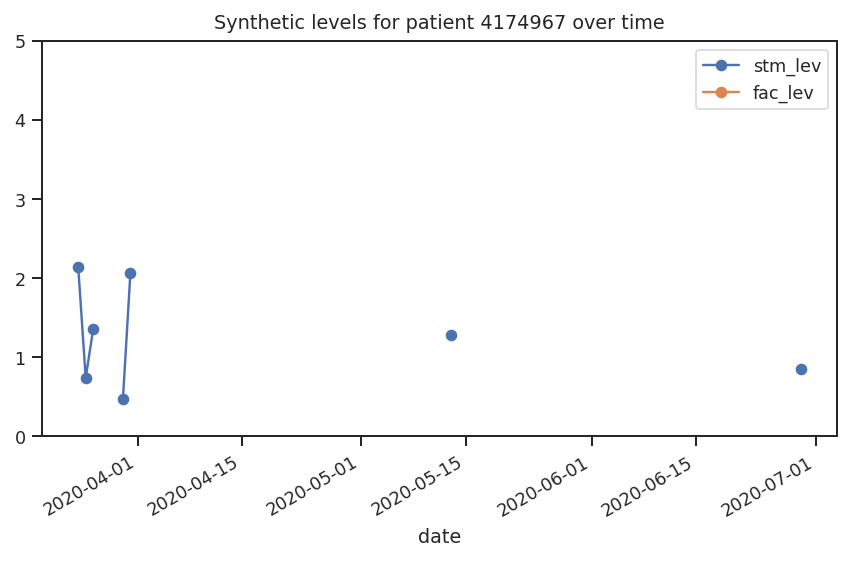

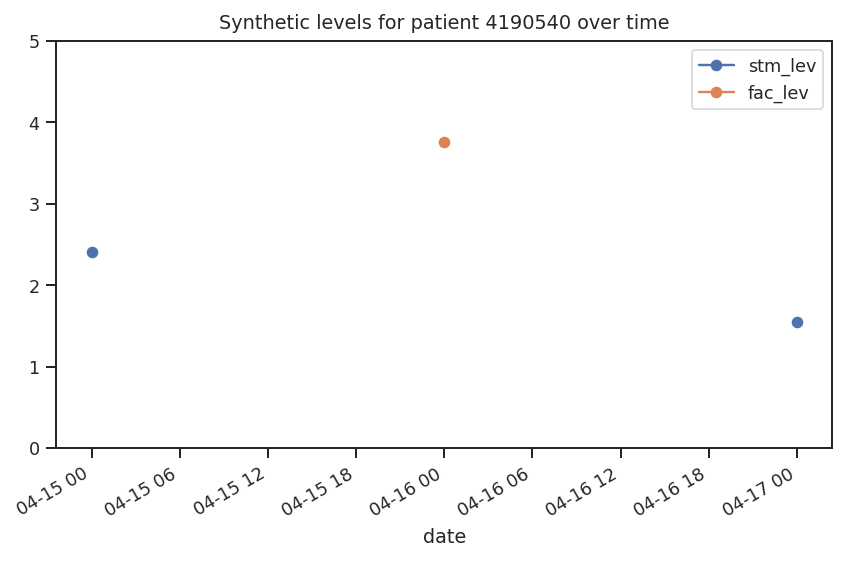

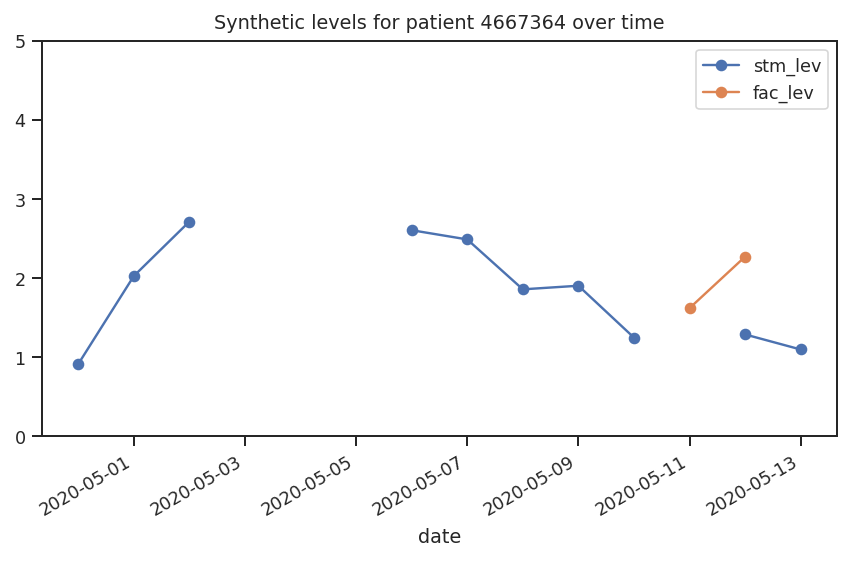

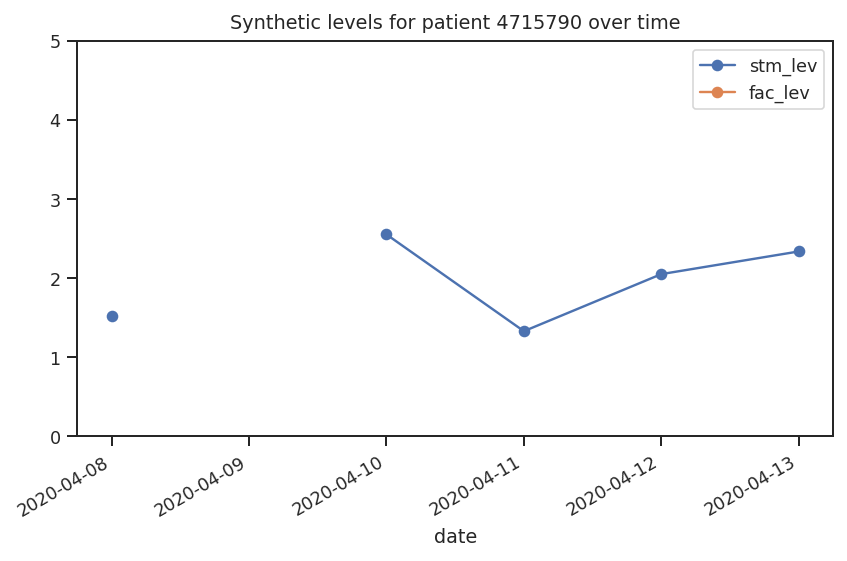

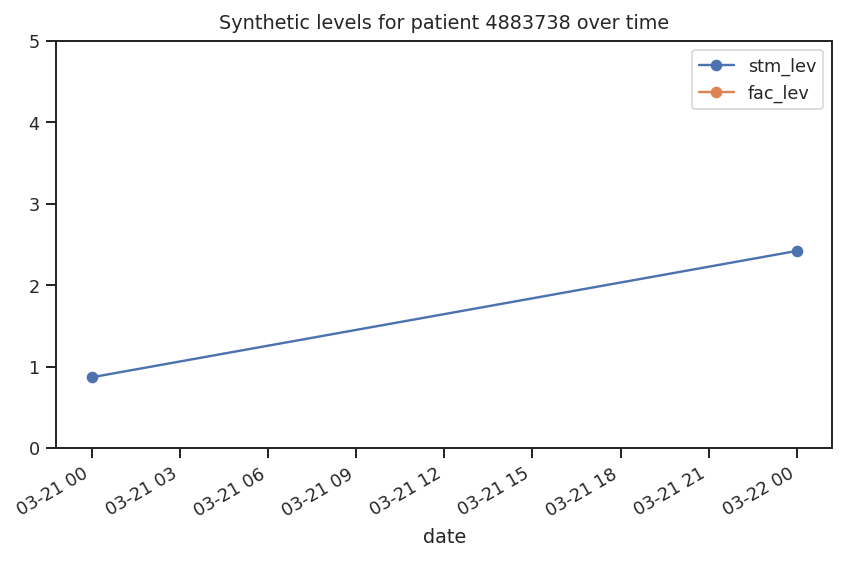

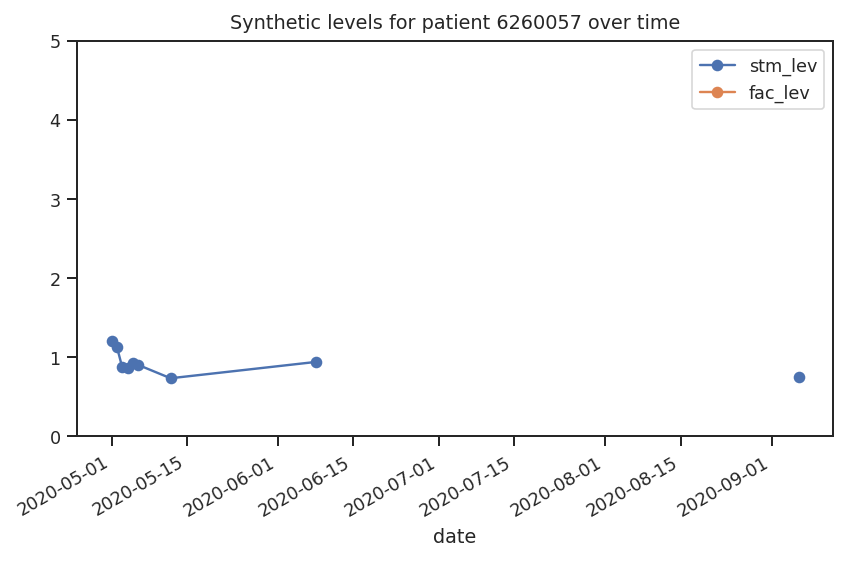

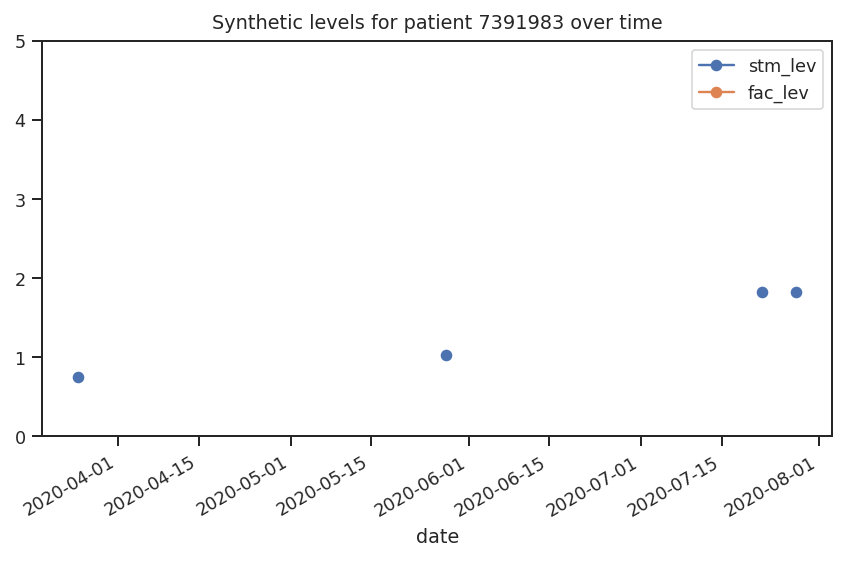

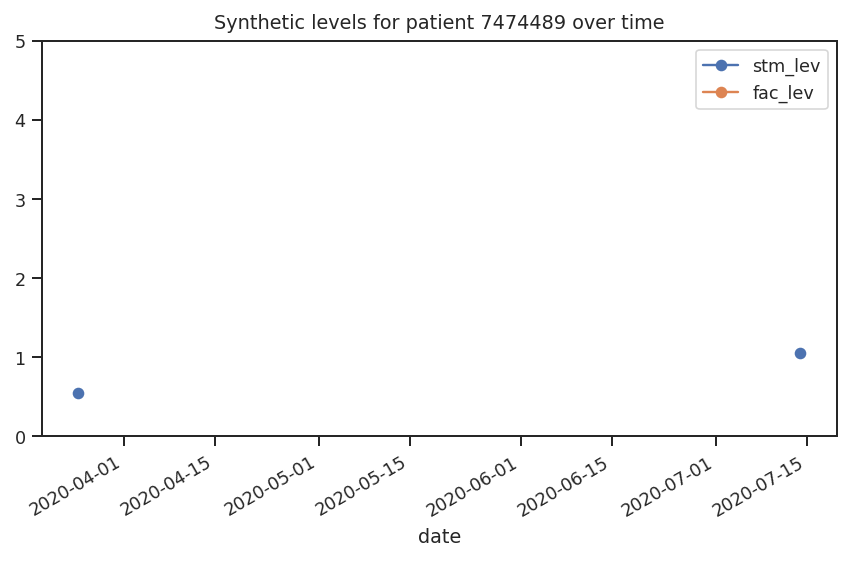

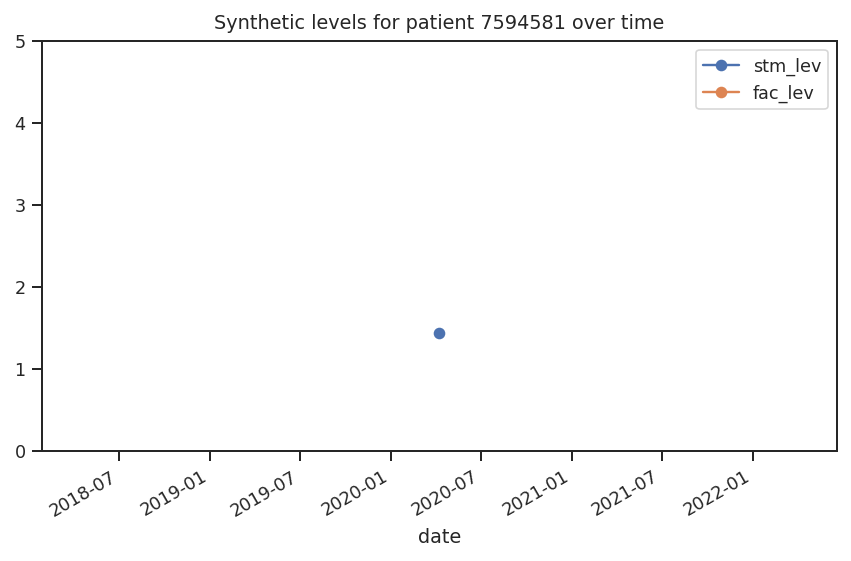

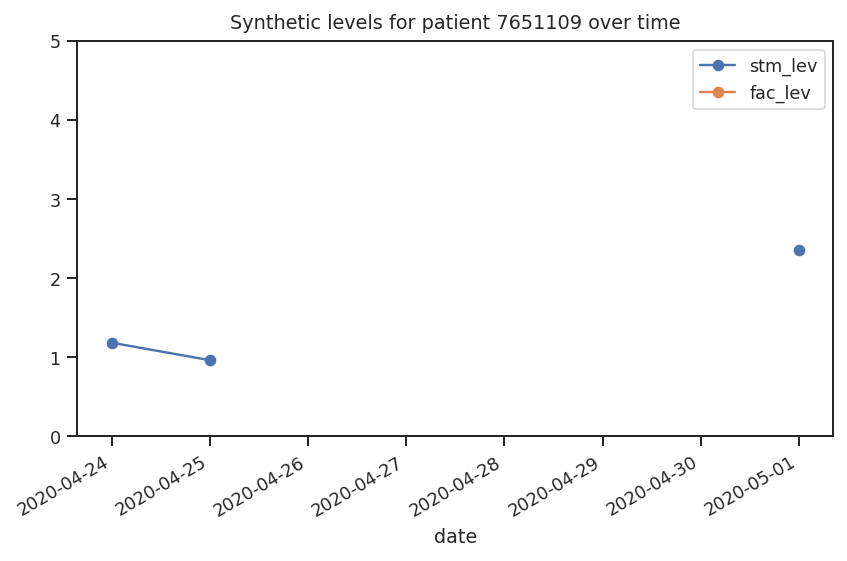

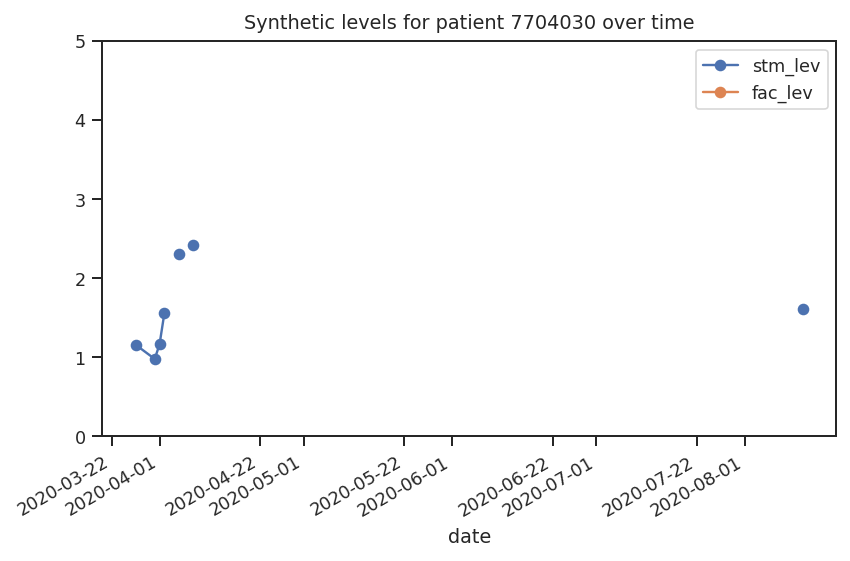

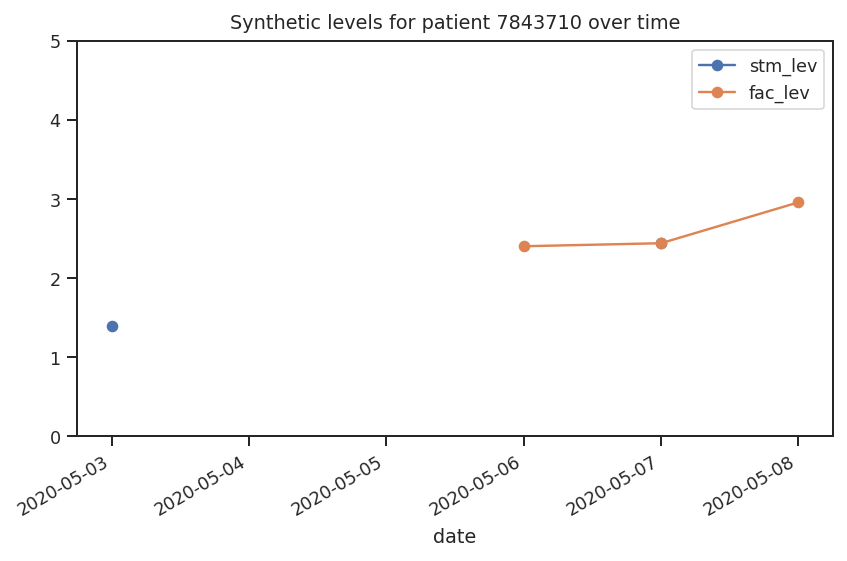

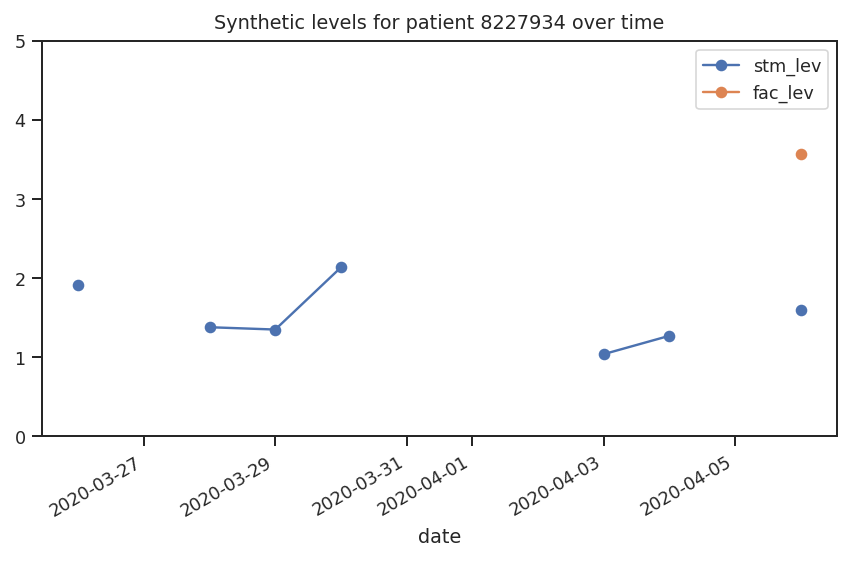

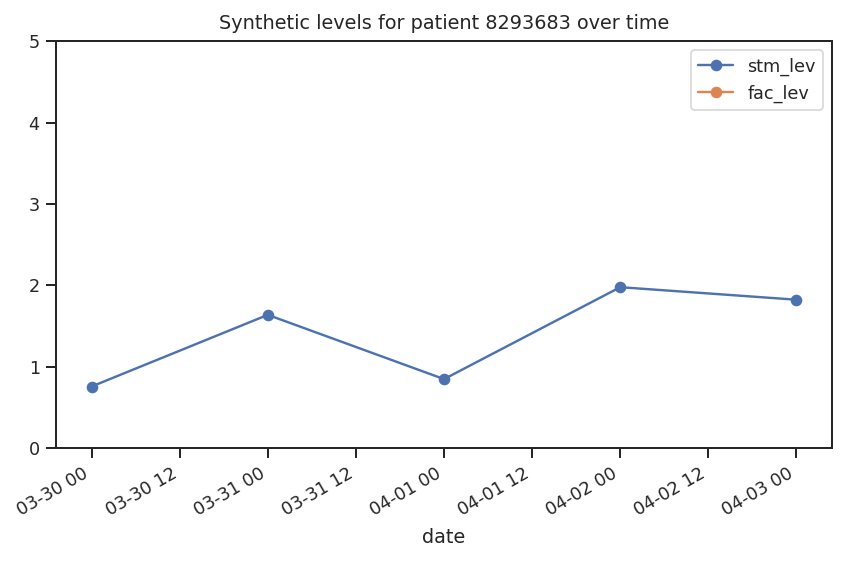

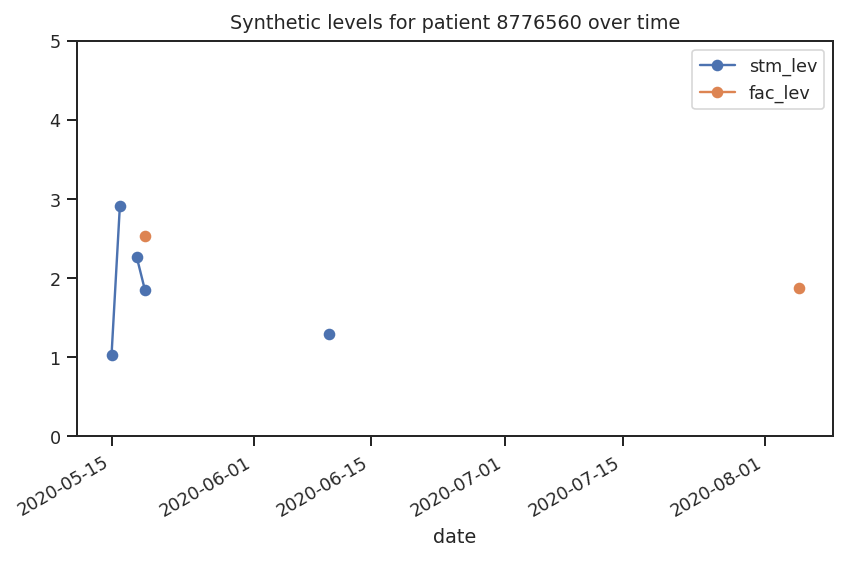

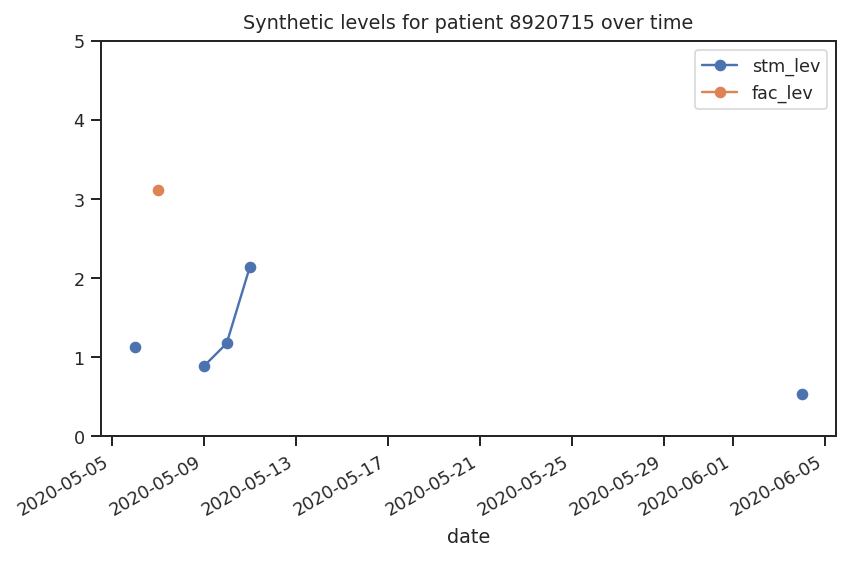

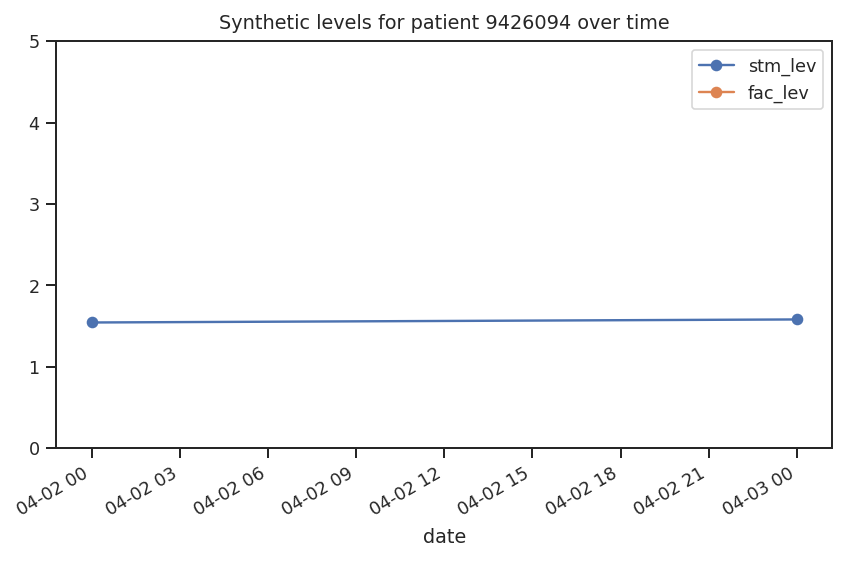

In [18]:
for pid in _df.patient_id.unique():
    data = _df[_df.patient_id == pid].sort_values(by='date', ascending=True)
    data['date'] = pd.to_datetime(data['date'])
    data.plot(x='date', y=DOMAINS, marker='o')
#     plt.xlim('2020-3-15', '2020-09-01')
    plt.ylim(0, 5)
    plt.title(f"Synthetic levels for patient {pid} over time")
    plt.tight_layout()
    plt.show()